In [2]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")
from nnsight import LanguageModel, CONFIG
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch as th
import torch  # for those who are afraid of th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from pathlib import Path
from time import time
import itertools
from dataclasses import dataclass
from warnings import warn
from random import shuffle, sample
# Fix logger bug
# import babelnet
from nnsight import logger

logger.disabled = True
th.set_grad_enabled(False)
import os

from dotenv import load_dotenv

load_dotenv()

True

## Get the prompts

In [3]:
batch_size = 16
from exp_tools import load_model

model = load_model("/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf")

from translation_tools import prompts_from_df, get_bn_dataset

de_df = get_bn_dataset("de", "de")
de_prompts = prompts_from_df("de", "de", de_df)
fr_df = get_bn_dataset("fr", "fr")
fr_prompts = prompts_from_df("fr", "fr", fr_df)

2024-06-17 18:43:04,002 [babelnet.conf] INFO: Loaded configuration from ['/dlabscratch1/veselovs/projects/llm-latent-language/babelnet_conf.yml']
2024-06-17 18:43:04,011 [babelnet.api] INFO: BabelNet online RESTful API v1.2.0


In [4]:
print(de_prompts[0])

Deutsch: "Ozean" - Deutsch: "Ozean"
Deutsch: "Lied" - Deutsch: "Lied"
Deutsch: "Norden" - Deutsch: "Norden"
Deutsch: "Schule" - Deutsch: "Schule"
Deutsch: "Osten" - Deutsch: "Osten"
Deutsch: "Buch" - Deutsch: "


## Compute the mean vector

In [5]:
from exp_tools import get_mean_activations
de_means = get_mean_activations(model, de_prompts, batch_size=batch_size)

  0%|          | 0/6 [00:00<?, ?it/s]

2024-06-17 18:44:46,104 [nnsight] INFO: Dispatching `/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf`...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-06-17 18:45:09,868 [nnsight] INFO: Dispatched `/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf`
2024-06-17 18:45:09,870 [nnsight] INFO: Running `/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf`...
2024-06-17 18:45:09,878 [nnsight] INFO: => SET(argument_0)
2024-06-17 18:45:09,881 [nnsight] INFO: => DEL(argument_0)
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2024-06-17 18:45:11,859 [nnsight] INFO: => SET(argument_1)
2024-06-17 18:45:11,865 [nnsight] INFO: => SET(getitem_0)
2024-06-17 18:45:11,991 [nnsight] INFO: => SET(getitem_1)
2024-06-17 18:45:11,995 [nnsight] INFO: => SET(fetch_attr_0)
2024-06-17 18:45:11,998 [nnsight] INFO: => SET(proxy_call_0)
2024-06-17 18:45:12,001 [nnsight] INFO: => DEL(fetch_attr_0)
2024-06-17 18:45:12,004 [nnsight] INFO: => DEL(getitem_1)
2024-06-17 18:45:12

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU  has a total capacity of 11.92 GiB of which 960.00 KiB is free. Process 2796309 has 5.15 GiB memory in use. Including non-PyTorch memory, this process has 6.76 GiB memory in use. Of the allocated memory 6.52 GiB is allocated by PyTorch, and 130.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
langs = ["fr", "es", "de", "it", "zh", "ru", "ja", "en"]
# all_df = get_bn_dataset("en", langs)

In [ ]:
steering_vectors = [neutral - de for de, neutral in zip(de_means, lang_means)]

In [ ]:
from exp_tools import collect_activations
buch_prompt = '"'.join(de_prompts[0].split('"')[:-2])
print(buch_prompt)
buch_latents = collect_activations(model, de_prompts[0])

Deutsch: "Auge" - Deutsch: "Auge"
Deutsch: "Linie" - Deutsch: "Linie"
Deutsch: "Person" - Deutsch: "Person"
Deutsch: "Punkt" - Deutsch: "Punkt"
Deutsch: "Tuch" - Deutsch: "Tuch"
Deutsch: "Buch


In [ ]:
neutral_buch = [buch + steering for buch, steering in zip(buch_latents, steering_vectors)]

In [ ]:
description_prompt = """Nuage: Un nuage est en météorologie une masse visible constituée initialement d'une grande quantité de gouttelettes d'eau en suspension dans l'atmosphère au-dessus de la surface d'une planète.
Stern: Unter einem Stern versteht man in der Astronomie einen massereichen, selbstleuchtenden Himmelskörper aus sehr heißem Gas und Plasma, wie zum Beispiel die Sonne.
Car: A car is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one to eight people, have four tires, and mainly transport people rather than goods.
Montagne: Une montagne est une forme topographique de relief positif, à la surface de planètes telluriques, et faisant partie d'un ensemble — une chaîne de montagnes — ou formant un relief isolé.
Tiger: The tiger (Panthera tigris) is the largest extant cat species and a member of the genus Panthera. It is most recognisable for its dark vertical stripes on orange-brown fur with a lighter underside.
Wave: In physics, mathematics, and related fields, a wave is a propagating dynamic disturbance (change from equilibrium) of one or more quantities, sometimes as described by a wave equation.
Wasser: Wasser ist insbesondere die chemische Verbindung H2O, bestehend aus den Elementen Sauerstoff und Wasserstoff.
Maison: Une maison est un bâtiment d'habitation, souvent de taille moyenne destiné au logement d'une famille ou de plusieurs, sans être considéré comme un immeuble collectif.
?"""

In [3]:
description_prompt = """Nuage: Un nuage est en météorologie une masse visible constituée initialement d'une grande quantité de gouttelettes d'eau en suspension dans l'atmosphère au-dessus de la surface d'une planète.
Étoile: Une étoile est en astronomie un corps céleste massif et lumineux constitué de gaz très chaud et de plasma, comme par exemple le Soleil.
Voiture: Une voiture est un véhicule motorisé à roues utilisé pour le transport. La plupart des définitions des voitures disent qu'elles roulent principalement sur les routes, peuvent transporter de une à huit personnes, ont quatre pneus, et transportent principalement des personnes plutôt que des marchandises.
Montagne: Une montagne est une forme topographique de relief positif, à la surface de planètes telluriques, et faisant partie d'un ensemble — une chaîne de montagnes — ou formant un relief isolé.
Tigre: Le tigre (Panthera tigris) est la plus grande espèce de chat existante et un membre du genre Panthera. Il est reconnaissable par ses rayures verticales sombres sur un pelage orange-brun avec un dessous plus clair.
Vague: En physique, en mathématiques et dans les domaines connexes, une vague est une perturbation dynamique propagative (changement d'équilibre) d'une ou de plusieurs quantités, parfois décrite par une équation d'onde.
Eau: L'eau est notamment la combinaison chimique H2O, constituée des éléments oxygène et hydrogène.
Maison: Une maison est un bâtiment d'habitation, souvent de taille moyenne destiné au logement d'une famille ou de plusieurs, sans être considéré comme un immeuble collectif.
?"""

In [4]:
from nnsight_utils import get_layer_output, get_next_token_probs
layer = 22
max_t = 20
with model.generate(description_prompt, max_new_tokens=max_t):
    get_layer_output(model, layer)[:, -1] = neutral_buch[layer]
    # probs = get_next_token_probs(model).save()
    gen = model.generator.output[0].cpu().save()
print(model.tokenizer.decode(gen))
with model.generate(description_prompt, max_new_tokens=max_t, do_sample=False):
    get_layer_output(model, layer)[:, -1] = buch_latents[layer]
    gen2 = model.generator.output[0].cpu().save()
print()
print(model.tokenizer.decode(gen2))
with model.generate(description_prompt, max_new_tokens=max_t):
    clean_gen = model.generator.output[0].cpu().save()
print()
print(model.tokenizer.decode(clean_gen))

NameError: name 'model' is not defined

/mnt/dlabscratch1/cdumas/llm-latent-language/generalization/../utils.py:490: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


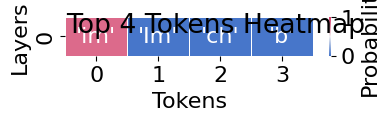

In [ ]:
plot_topk_tokens(probs.cpu(), model.tokenizer)

## Steer using a random lang task

In [ ]:
buch_latents

[tensor([[ 0.0074,  0.0091,  0.0113,  ..., -0.0054,  0.0243,  0.0221]],
        dtype=torch.float16),
 tensor([[-0.0018,  0.0263,  0.0040,  ...,  0.0092,  0.0114,  0.0438]],
        dtype=torch.float16),
 tensor([[-0.0171,  0.0144, -0.0501,  ...,  0.0216,  0.0551,  0.0649]],
        dtype=torch.float16),
 tensor([[ 0.0205,  0.0162,  0.0285,  ..., -0.0180,  0.0374,  0.0724]],
        dtype=torch.float16),
 tensor([[-0.0543,  0.0367, -0.0488,  ...,  0.0764,  0.1110,  0.0266]],
        dtype=torch.float16),
 tensor([[-0.0673,  0.0841, -0.0594,  ...,  0.1548,  0.1089,  0.0637]],
        dtype=torch.float16),
 tensor([[-0.0536,  0.0687,  0.0349,  ...,  0.3406,  0.0548,  0.0829]],
        dtype=torch.float16),
 tensor([[-0.0589, -0.0059,  0.0112,  ...,  0.2668, -0.0408,  0.0162]],
        dtype=torch.float16),
 tensor([[-0.0770, -0.0472,  0.1699,  ...,  0.2261, -0.1440,  0.1880]],
        dtype=torch.float16),
 tensor([[-0.1116,  0.1022,  0.0139,  ...,  0.2405, -0.0396,  0.2170]],
        dt

In [ ]:
from random import sample
dataset = {
    "A": [],
    "B": [],
}
num_rep = 5
for _, row in all_df.iterrows():
    dataset["A"].

In [ ]:
prompt = "A: cat, B: Katze\nA:DOG^FR, B: DOG^ZH\nA:CLOUD^RU\nB:"

94